# Global Entity Comparison across Pathway Databases

This notebook evaluates the degree of consensus for different modalities across KEGG [1], Reactome [2], and WikiPathways [3]. The notebook was generated with data parsed on the 16th of January, 2019

Author: [Daniel Domingo-Fernández](https://github.com/ddomingof)

1. Kanehisa, M., *et al.* (2016). `KEGG: new perspectives on genomes, pathways, diseases and drugs.` *Nucleic acids research*, 45(D1), D353-D361.

2. Fabregat, A., *et al.* (2017). ` The reactome pathway knowledgebase.` *Nucleic acids research*, 46(D1), D649-D655.

3. Slenter, D. N., *et al.* (2017). `WikiPathways: a multifaceted pathway database bridging metabolomics to other omics research.` *Nucleic acids research*, 46(D1), D661-D667.

4. Domingo-Fernández, D., *et al.* (2019). `ComPath: An ecosystem for exploring, analyzing, and curating mappings across pathway databases.` *npj Syst Biol Appl.*, 5(1):3.

5. Stobbe, D. M., *et al.* (2011). `Critical assessment of human metabolic pathway databases: a stepping stone for future integration.` *BMC systems biology*, 5.1: 165.

In [33]:
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

import pybel
import pybel_tools

from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction

from pybel.struct.filters.node_predicate_builders import function_inclusion_filter_builder

from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL

##### Notebook and dependencies metainformation

In [34]:
sys.version

'3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) \n[GCC 7.2.0]'

In [35]:
time.asctime()

'Wed Jan 16 14:32:08 2019'

In [36]:
%matplotlib inline

In [37]:
pybel.get_version()

'0.13.1'

In [38]:
pybel_tools.get_version()

'0.7.0'

##### Load merge database networks (_Network pickles should be placed in the default directory..._)

If you have not parsed the databases with PathMe, you can simply download the files here and move them to 
your local directory under: 

__./.pathme/{database}/bel (e.g., /home/daniel/.pathme/kegg/bel) __

Download link for KEGG pickles
https://drive.google.com/uc?authuser=0&id=1a_6lck28Df9v2E-Dt45-ZARsdGVs-V9s&export=download

Download link for Reactome pickles
https://owncloud.scai.fraunhofer.de/index.php/s/WH7CybmsxN4eXMH/download

Download link for WikiPathways pickles
https://drive.google.com/uc?authuser=0&id=1adwTE9cUpMb0lFiN0gbrGLaWfExtFdux&export=download 

In [7]:
# Modify Python Typing arguments if you are using Python < 3.6
# PyBEL union method cannot be used because empty nodes are discarded
def get_nodes_in_database(folder):
    """Merge all the python pickles in a given folder and returns the corresponding BELGraph."""  
    database_networks = [
        pybel.from_pickle(os.path.join(folder, path))
        for path in os.listdir(folder)
        if path.endswith('.pickle')
    ]
    
    return {
        node
        for network in database_networks
        for node in network.nodes()
    }

In [8]:
kegg_nodes = get_nodes_in_database(KEGG_BEL)
reactome_nodes = get_nodes_in_database(REACTOME_BEL)
wikipathways_nodes = get_nodes_in_database(WIKIPATHWAYS_BEL)

#### Manual Curation
Since some of the entities were not categorized with their corresponding BEL function (e.g., abundance, gene) due to abnormalities in harmonization, we have manually curated them and assigned them to the right modality.

This data can be used by the original database to correct the node label in their corresponding pathway files.

In [9]:
# Entities in WikiPathways that required manual curation
WIKIPATHWAYS_BIOL_PROCESS = {'lipid biosynthesis', 'hsc survival', 'glycolysis & gluconeogenesis', 'triacylglyceride  synthesis', 'wnt canonical signaling', 'regulation of actin skeleton', 'fatty acid metabolism', 'mrna processing major splicing pathway', 'senescence', 'monocyte differentiation', 'pentose phosphate pathway', 'ethanolamine  phosphate', 'hsc differentiation', 'actin, stress fibers and adhesion', 'regulation of actin cytoskeleton', 's-phase progression', 'g1-s transition', 'toll-like receptor signaling pathway', 'regulation of  actin cytoskeleton', 'proteasome degradation', 'apoptosis', 'bmp pathway', 'ampk activation', 'g1/s checkpoint arrest', 'mapk signaling pathway', 'chromatin remodeling and  epigenetic modifications', 'wnt signaling pathway', 'ros production', 'erbb signaling pathway', 'shh pathway', 'inflammation', 'dna replication', 'mrna translation', 'oxidative stress', 'cell cycle checkpoint activation', 'gi/go pathway', 'wnt pathway', 'g1/s transition of mitotic cell cycle', 'modulation of estrogen receptor signalling', 'dna repair', 'bmp canonical signaling', 'igf and insuline signaling', 'unfolded protein response', 'cell death', 'p38/mapk  pathway', 'glycogen metabolism', 'gnrh signal pathway', 'the intra-s-phase checkpoint mediated arrest of cell cycle progression', 'tca cycle', 'mtor protein kinase signaling pathway', 'proteasome  degradation pathway', 'morphine metabolism', 'hsc aging', 'gastric pepsin release', 'parietal cell production', 'prostaglandin pathway', 'cell cycle (g1/s)  progression', 'notch pathway', 'g2/m progression', 'wnt signaling', 'cell adhesion', 'cell cycle progression', 'egfr pathway', 'cell cycle', 'angiogenesis', 'g2/m-phase checkpoint', 'hsc self renewal', '26s proteasome  degradation', 'mapk signaling', 'immune system up or down regulation', 'm-phase progression', 'insulin signaling', 'nf kappa b pathway', 'cell cycle  progression', 'gi pathway', 'cd45+ hematopoietic-    derived cell    proliferation', "kreb's cycle", 'glycogen synthesis', 'apoptosis pathway', 'g1/s progression', 'inflammasome activation', 'melanin biosynthesis', 'proteasomal degradation', 'g2/m checkpoint arrest', 'g1/s cell cycle transition', 'dna damage response', 'gastric histamine release'}
WIKIPATHWAYS_METAB = {'2,8-dihydroxyadenine', '8,11-dihydroxy-delta-9-thc', 'adp-ribosyl', 'cocaethylene', 'dhcer1p', 'ecgonidine', 'f2-isoprostane', 'fumonisins b1', 'iodine', 'l-glutamate', 'lactosylceramide', 'methylecgonidine', 'n-acetyl-l-aspartate', 'nad+', 'nadph oxidase', 'neuromelanin', 'nicotinic acid (na)', 'nmn', 'pip2', 'sphingomyelin', 'thf'}
WIKIPATHWAYS_NAME_NORMALIZATION = {"Ca 2+": "ca 2+", "acetyl coa": "acetyl-coa", "acetyl-coa(mit)": "acetyl-coa", "h20": "h2o"}

# Entities in Reactome that required manual curation
BLACK_LIST_REACTOME = {"5'"}
REACTOME_PROT = {'phospho-g2/m transition proteins', 'integrin alpha5beta1, integrin alphavbeta3, cd47', 'food proteins', 'activated fgfr2', 'adherens junction-associated proteins', 'pi3k mutants,activator:pi3k', 'prolyl 3-hydroxylases', 'gpi-anchored proteins', 'c3d, c3dg, ic3b', 'c4s/c6s chains', 'activated fgfr1 mutants and fusions', 'activated fgfr3 mutants', 'protein', 'cyclin a2:cdk2 phosphorylated g2/m transition protein', 'c4c, c3f', 'activated raf/ksr1', 'activated fgfr1 mutants', 'g2/m transition proteins', 'lman family receptors', 'cyclin', 'usp12:wdr48:wdr20,usp26', 'proteins with cleaved gpi-anchors', 'activated fgfr2 mutants', 'c4d, ic3b', 'c5b:c6:c7, c8, c9', 'cyclin a1:cdk2 phosphorylated g2/m transition protein', 'genetically or chemically inactive braf', 'il13-downregulated proteins', 'activated fgfr4 mutants', 'rna-binding protein in rnp (ribonucleoprotein) complexes', 'effector proteins', 'usp3, saga complex', 'dephosphorylated "receiver" raf/ksr1'}

##### Methods used in this notebook to process node information and create a set for each modality/database

In [10]:
def process_reactome_multiple_genes(genes):
    """Process a wrong ID with multiple identifiers"""
    gene_list = []
    for counter, gene in enumerate(genes):
        
        # Strip the ' gene' prefix
        gene = gene.strip().strip(' gene').strip(' genes')
        
        # First element is always OK
        if counter == 0:
            gene_list.append(gene)
        
        # If the identifier starts the same than the first one, it is right
        elif gene[:2] == genes[0][:2]:
            gene_list.append(gene)
        
        # If the identifier is longer than 2 it is a valid HGNC symbol
        elif len(gene) > 2:
            gene_list.append(gene)
 
        # If they start different, it might have only a number (e.g., 'ABC1, 2, 3') so it needs to be appended
        elif gene.isdigit():
            gene_list.append(genes[0][:-1] + gene)
        
        # If the have only one letter (e.g., HTR1A,B,D,E,F,HTR5A)
        elif len(gene) == 1:
            gene_list.append(genes[0][:-1] + gene)
            
    return gene_list
    
def munge_reactome_gene(gene):
    """Process Reactome gene"""
    if "," in gene:
        return process_reactome_multiple_genes(gene.split(","))
        
    elif "/" in gene:
        return process_reactome_multiple_genes(gene.split("/"))
    
    return gene

def calculate_database_sets(nodes, database):
    """Calculate node sets for each modality in the database"""
    gene_nodes = set()
    mirna_nodes = set()
    metabolite_nodes = set()
    bp_nodes = set()
    
    for node in nodes:
        
        if isinstance(node, ListAbundance) or isinstance(node, Reaction) or not node.name:
            continue
                
        # Lower case name and strip quotes or white spaces
        name = node.name.lower().strip('"').strip()
        
        # Dealing with Genes/miRNAs
        if isinstance(node, CentralDogma):
            
            ##################
            # miRNA entities #
            ##################
            
            if name.startswith("mir"):
                
                # Reactome preprocessing to flat multiple identifiers
                if database == 'reactome':
                    reactome_cell = munge_reactome_gene(name)
                    if isinstance(reactome_cell, list):
                        for name in reactome_cell:
                            mirna_nodes.add(name.replace("mir-", "mir"))
                    else:
                        mirna_nodes.add(name.strip(' genes').replace("mir-", "mir"))
                        
                    continue
                
                mirna_nodes.add(name.replace("mir-", "mir"))
                
            ##################
            # Genes entities #
            ##################
            
            else:
                # Reactome preprocessing to flat multiple identifiers
                if database == 'reactome':
                    reactome_cell = munge_reactome_gene(name)
                    if isinstance(reactome_cell, list):
                        for name in reactome_cell:
                            if name in BLACK_LIST_REACTOME: # Filter entities in black list
                                continue
                            elif name.startswith("("): # remove redundant parentheses
                                name = name.strip("(").strip(")")
                                
                            gene_nodes.add(name)
                    else:
                        gene_nodes.add(name)
                    continue
                    
                # WikiPathways and KEGG do not require any processing of genes
                if name in WIKIPATHWAYS_BIOL_PROCESS:
                    bp_nodes.add(name)
                    continue
                gene_nodes.add(name)
         
        #######################
        # Metabolite entities #
        #######################
        
        elif isinstance(node, Abundance):
            
            if database == 'wikipathways':
                # Biological processes that are captured as abundance in BEL since they were characterized wrong in WikiPathways
                if name in WIKIPATHWAYS_BIOL_PROCESS:
                    bp_nodes.add(name)
                    continue

                elif node.namespace in {'WIKIDATA', 'WIKIPATHWAYS', 'REACTOME'} and name not in WIKIPATHWAYS_METAB:
                    bp_nodes.add(name)
                    continue
                    
                # Fix naming in duplicate entity
                if name in WIKIPATHWAYS_NAME_NORMALIZATION:
                    name = WIKIPATHWAYS_NAME_NORMALIZATION[name]
                    
            elif database == 'reactome':
                # Curated proteins that were coded as metabolites
                if name in REACTOME_PROT:
                    gene_nodes.add(name)
                    continue
                
                # Flat multiple identifiers (this is not trivial because most of ChEBI names contain commas, 
                # so a clever way to fix some of the entities is to check that all identifiers contain letters)
                elif "," in name and all(
                    string.isalpha() 
                    for string in name.split(",")
                ):
                    for string in name.split(","):
                        metabolite_nodes.add(name)
                    continue
                    
            metabolite_nodes.add(name)

        #################################
        # Biological Processes entities #
        #################################
        
        elif isinstance(node, BiologicalProcess):
            if name.startswith('title:'):
                name = name[6:] # KEGG normalize
            
            bp_nodes.add(name)
        
    return gene_nodes, mirna_nodes, metabolite_nodes, bp_nodes

In [11]:
kegg_genes, kegg_mirna, kegg_metabolites, kegg_bps = calculate_database_sets(
    kegg_nodes, 'kegg'
)

reactome_genes, reactome_mirna, reactome_metabolites, reactome_bps = calculate_database_sets(
    reactome_nodes, 'reactome'
)
wikipathways_genes, wikipathways_mirna, wikipathways_metabolites, wikipathways_bps = calculate_database_sets(
    wikipathways_nodes, 'wikipathways'
)

#### Entity count for each modality in each database

In [12]:
print(f'Total number of genes: KEGG ({len(kegg_genes)}), Reactome ({len(reactome_genes)}), WikiPathways ({len(wikipathways_genes)})')

print(f'Total number of metabolites: KEGG ({len(kegg_metabolites)}), Reactome ({len(reactome_metabolites)}), WikiPathways ({len(wikipathways_metabolites)})')

print(f'Total number of miRNAs: KEGG ({len(kegg_mirna)}), Reactome ({len(reactome_mirna)}), WikiPathways ({len(wikipathways_mirna)})')

print(f'Total number of Biological Processes: KEGG ({len(kegg_bps)}), Reactome ({len(reactome_bps)}), WikiPathways ({len(wikipathways_bps)})')

Total number of genes: KEGG (7289), Reactome (6342), WikiPathways (3025)
Total number of metabolites: KEGG (4048), Reactome (2553), WikiPathways (454)
Total number of miRNAs: KEGG (149), Reactome (11), WikiPathways (68)
Total number of Biological Processes: KEGG (418), Reactome (2101), WikiPathways (102)


Consensus nodes

In [13]:
len(kegg_genes.intersection(reactome_genes).intersection(wikipathways_genes))

1259

In [14]:
len(kegg_metabolites.intersection(reactome_metabolites).intersection(wikipathways_metabolites))

26

In [15]:
len(kegg_mirna.intersection(reactome_mirna).intersection(wikipathways_mirna))

3

In [16]:
len(kegg_bps.intersection(reactome_bps).intersection(wikipathways_mirna))

0

In [17]:
#########
# Genes #
#########

genes_total = kegg_genes | reactome_genes | wikipathways_genes

genes_consensus = kegg_genes.intersection(reactome_genes).intersection(wikipathways_genes)
genes_2_dbs = (((kegg_genes & reactome_genes) | (wikipathways_genes & reactome_genes)) | (wikipathways_genes & kegg_genes)) - genes_consensus

gene_unique_kegg = (kegg_genes - reactome_genes) - wikipathways_genes
gene_unique_reactome = (reactome_genes - kegg_genes) - wikipathways_genes
gene_unique_wp = (wikipathways_genes - kegg_genes) - reactome_genes

# Unique KEGG +  Unique Reactome + Unique Wikipathways
genes_unique = gene_unique_kegg |  gene_unique_reactome | gene_unique_wp

pct_gene_consensus = (len(genes_consensus)/ len(genes_total)) * 100
pct_gene_2_dbs = (len(genes_2_dbs)/ len(genes_total)) * 100
pct_gene_unique = (len(genes_unique)/ len(genes_total)) * 100

###############
# Metabolites # 
###############

metabolites_total = kegg_metabolites | reactome_metabolites | wikipathways_metabolites

metabolites_consensus = kegg_metabolites & reactome_metabolites & wikipathways_metabolites
metabolites_2_dbs = (((kegg_metabolites & reactome_metabolites) | (wikipathways_metabolites & reactome_metabolites)) | (wikipathways_metabolites & kegg_metabolites)) - metabolites_consensus

metabolites_unique_kegg = (kegg_metabolites - reactome_metabolites) - wikipathways_metabolites
metabolites_unique_reactome = (reactome_metabolites - kegg_metabolites) - wikipathways_metabolites
metabolites_unique_wp = (wikipathways_metabolites - kegg_metabolites) - reactome_metabolites

# Unique KEGG +  Unique Reactome + Unique Wikipathways
metabolites_unique = metabolites_unique_kegg |  metabolites_unique_reactome | metabolites_unique_wp

pct_metabolites_consensus = (len(metabolites_consensus)/ len(metabolites_total)) * 100
pct_metabolites_2_dbs = (len(metabolites_2_dbs)/ len(metabolites_total)) * 100
pct_metabolites_unique = (len(metabolites_unique)/ len(metabolites_total)) * 100

##########
# miRNAS # 
##########

mirna_total = kegg_mirna | reactome_mirna | wikipathways_mirna

mirna_consensus = kegg_mirna & reactome_mirna & wikipathways_mirna
mirna_2_dbs = (((kegg_mirna & reactome_mirna) | (wikipathways_mirna & reactome_mirna)) | (wikipathways_mirna & kegg_mirna)) - mirna_consensus

mirna_unique_kegg = (kegg_mirna - reactome_mirna) - wikipathways_mirna
mirna_unique_reactome = (reactome_mirna - kegg_mirna) - wikipathways_mirna
mirna_unique_wp = (wikipathways_mirna - kegg_mirna) - reactome_mirna

# Unique KEGG +  Unique Reactome + Unique Wikipathways
mirna_unique = mirna_unique_kegg |  mirna_unique_reactome | mirna_unique_wp

pct_mirna_consensus = (len(mirna_consensus)/ len(mirna_total)) * 100
pct_mirna_2_dbs = (len(mirna_2_dbs)/ len(mirna_total)) * 100
pct_mirna_unique = (len(mirna_unique)/ len(mirna_total)) * 100


########################
# Biological Processes # 
########################

bps_total = kegg_bps | reactome_bps | wikipathways_bps

bps_consensus = kegg_bps & reactome_bps & wikipathways_bps
bps_2_dbs = (((kegg_bps & reactome_bps) | (wikipathways_bps & reactome_bps)) | (wikipathways_bps & kegg_bps)) - bps_consensus

bps_unique_kegg = (kegg_bps - reactome_bps) - wikipathways_bps
bps_unique_reactome = (reactome_bps - kegg_bps) - wikipathways_bps
bps_unique_wp = (wikipathways_bps - kegg_bps) - reactome_bps

# Unique KEGG +  Unique Reactome + Unique Wikipathways
bps_unique = bps_unique_kegg |  bps_unique_reactome | bps_unique_wp

pct_bps_consensus = (len(bps_consensus)/ len(bps_total)) * 100
pct_bps_2_dbs = (len(bps_2_dbs)/ len(bps_total)) * 100
pct_bps_unique = (len(bps_unique)/ len(bps_total)) * 100

##### Visualize results

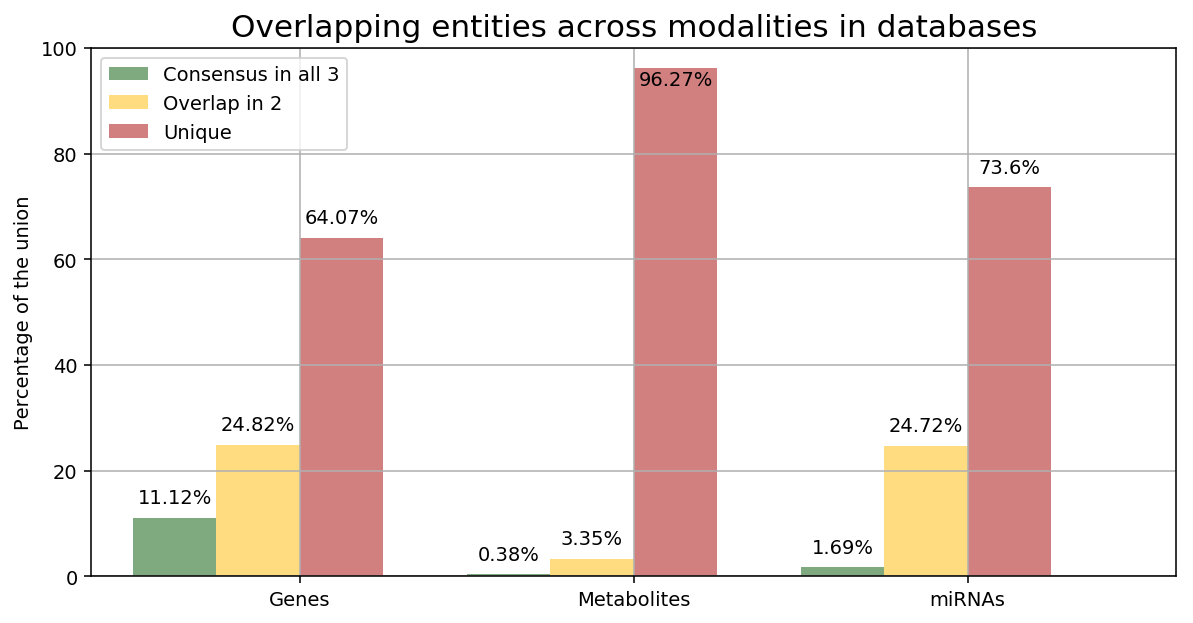

In [18]:
raw_data = {
    'modality': ['Genes', 'Metabolites', 'miRNAs'],
    'Consensus in all 3': [pct_gene_consensus, pct_metabolites_consensus, pct_mirna_consensus],
    'Overlap in 2': [pct_gene_2_dbs, pct_metabolites_2_dbs, pct_mirna_2_dbs],
    'Unique': [pct_gene_unique, pct_metabolites_unique, pct_mirna_unique]
}

df = pd.DataFrame(
    raw_data, 
    columns = ['modality', 'Consensus in all 3', 'Overlap in 2', 'Unique']
)

# Setting the positions and width for the bars
pos = list(range(len(df['Consensus in all 3']))) 
width = 0.25 
    
fig = plt.figure(figsize=(10, 5), dpi=140)

ax = plt.gca()

plt.bar(
    pos, 
    df['Consensus in all 3'], 
    width, 
    color='#005400', 
    alpha=0.5, 
    label=df['modality'][0]
)

plt.bar(
    [p + width for p in pos], 
    df['Overlap in 2'],
    width, 
    color='#ffba00', 
    alpha=0.5, 
    label=df['modality'][1]
)

plt.bar(
    [p + width*2 for p in pos], 
    df['Unique'], 
    width, 
    alpha=0.5, 
    color='#a50000', 
    label=df['modality'][2]
)

ax.set_ylabel('Percentage of the union')
ax.set_title('Overlapping entities across modalities in databases', fontsize = 16)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['modality'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 100])

# Add values to the chart
rects = ax.patches

values = [
    pct_gene_consensus, pct_metabolites_consensus, pct_mirna_consensus, 
    pct_gene_2_dbs, pct_metabolites_2_dbs, pct_mirna_2_dbs, 
    pct_gene_unique, pct_metabolites_unique, pct_mirna_unique
]

for rect, label in zip(rects, values):
    height = rect.get_height()
    
    if label > 90:
        ax.text(
            rect.get_x() + rect.get_width() / 2, height - 4, 
            "{}%".format(round(label, 2)),
            ha='center', va='bottom'
        )

    else:
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 2, 
            "{}%".format(round(label, 2)),
            ha='center', va='bottom'
        )

# Adding the legend and showing the plot
plt.legend(['Consensus in all 3', 'Overlap in 2', 'Unique'], loc='upper left')
plt.grid()
plt.show()

__Figure 1.__ Overlapping entities across modalities in the three databases studied (i.e., KEGG, Reactome, and WikiPathways). 

We find the degree of consensus of biological entities across all three databases (green bars) to be relatively low, albeit variable across the assessed modalities. The proportion of genes present in all databases is similar to the results obtained by [5] (15%), although they have exclusively focused their work on metabolic pathways. Total consensus of miRNAs in all three databases was unsurprisingly low due to a disproportionate representation of miRNA species across the databases. Specifically, as few as 11 miRNAs derived from Reactome while 149 were present in KEGG. By contrast, the total consensus for metabolites is grossly deficient at less than 1%. This particularly low level of overlap for the metabolite modality can be largely attributed to several reasons that we will later discuss.

While for partial overlap (yellow bars) we observed similar results for genes and miRNAs, both having approximately one fourth (25%) of overlap, the metabolite modality exhibited relatively low levels of overlap (~4%). Accordingly, we find that the proportion of distinct entities (red bars) is substantially higher than those present in any two or all three databases. 

There are several reasons that can explain the observed results:

1. Disproportionate representation of each modality across databases __(Table 1)__. By definition, having sets with significant variations in cardinality (i.e., set size) limits the likelihood of consensus since only a portion of the larger sets can intersect with the smaller ones. For instance, since KEGG contains 4048 metabolites and WikiPathways 454, the maximum consensus is constrained to the metabolites contained in WikiPathways (in this case the maximum overlap would be 11.22% overlap).

2. Each database places distinct emphases on discrete aspects or regions of biological pathways, as outlined by [4] who reported only 21 equivalent pathways between the three databases. Therefore, despite the presence of key biological players in all three databases, the majority of biological entities are particular to a single database. For example, over 200 glycan molecules are present in KEGG since this resource contains multiple pathways related to Glycan metabolism (i.e., "Glycan biosynthesis and metabolism") while they are absent in the others.

3. Some entity identifiers have no discernible mapping to major standard nomenclatures because they exhibit a high degree of specificity. This is particularly noted for genes where curators captured entities such as specific protein events (e.g., "p-y641-stat6"), protein mutations (e.g., "activated fgfr1 mutants"), protein families (e.g., "lim kinases"), protein fragments (e.g., "ub c-terminal hh fragments"), or splicing events (e.g., "xbp1 mrna (spliced)"). A way to account for these high granular cases would be to standardized protein families with resources such as Pfam or FamPlex. For cases such as protein fragments or events, BEL enables their harmonization by incorporating them into its syntax (http://openbel.org/language/version_2.0/bel_specification_version_2.0.html).
 

|Modality|KEGG|Reactome|WikiPathways|
|------|------|------|------|
|Genes |7289|6342|3025|
|Metabolites|4048|2553|454|
|miRNAs |149|11|68|
|Biological Processes |418|2101|102|
<center> __Table 1.__ Unique entities in each modality for each database <center>